In [99]:
from top2vec import Top2Vec
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0,'../..')
import lib.db as db

In [100]:
# input_db = 'newspaper_300'
# input_collection = 'article'
input_db = 'iran_news'
input_collection = 'articles'
article_col = db.get_collection(input_db, input_collection)
article_df = db.get_articles(article_col, links=False)

In [101]:
import os
hierarchical = False
num_topics = 20

# paraphrase-multilingual-MiniLM-L12-v2, and all-MiniLM-L6-v2
# pretrained_model = 'distiluse-base-multilingual-cased' # multilingual-accurate
model_name = 'paraphrase-multilingual-MiniLM-L12-v2'

if hierarchical:
    if os.path.exists('../../models/top2vec_'+input_db+'_hierarchical_dump'):
        model = Top2Vec.load('../../models/top2vec_'+input_db+'_hierarchical_dump')
    else:
        model=Top2Vec.load('../../models/top2vec_'+input_db+'_dump')
        model.hierarchical_topic_reduction(num_topics=num_topics)
        # model.save('../../models/top2vec_'+input_db+'_hierarchical_dump')
else:
    if os.path.exists('../../models/top2vec_'+model_name+input_db+'_seo_dump'):
        model = Top2Vec.load('../../models/top2vec_'+model_name+input_db+'_seo_dump')
    else:
        model = Top2Vec(documents=article_df['text'].to_numpy(), speed="learn", workers=8, embedding_model=model_name, keep_documents=True)
        model.save('../../models/top2vec_'+model_name+input_db+'_seo_dump')
    

2024-05-14 17:20:42,129 - top2vec - INFO - Pre-processing documents for training
/home/peter/miniconda3/envs/iran_news/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

2024-05-14 17:20:49,962 - top2vec - INFO - Downloading paraphrase-multilingual-MiniLM-L12-v2 model
/home/peter/miniconda3/envs/iran_news/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

2024-05-14 17:21:00,783 - top2vec - INFO - Creating joint document/word embedding
2024-05-14 17:21:17,606 - top2vec - INFO - Creating lower dimension embedding of documents
2024-05-14 17:21:22,095 - top2vec - INFO - Finding dense areas of documents
2024-05-14 17:21:22,250 - top2vec - INFO - Finding topics


In [102]:
from googletrans import Translator
import time

def translate_word(topic):
    try:
        translator = Translator()
        time.sleep(0.1)
        translation = translator.translate(topic, src='fa', dest='en')  # Specify source language as Farsi
        return translation.text
    except:
        return ""
    

if hierarchical:
    topic_words, word_scores, topic_nums = model.get_topics(num_topics, reduced=True)
else:
    topic_words, word_scores, topic_nums = model.get_topics()
concepts = [' '.join([translate_word(w) for w in list[:8]]) for list in topic_words]
concepts

['Warning basically Muslim Principle Friends Candidate Explicitly I will',
 'Israel Israel Gaza Palestinians Israeli Hamas Palestine Netanyahu',
 'cyber Telecommunications Technology Internet Figure Technology Technology digital',
 'Cinema the cinema CinemaPress Filmmaker Cinematographers Filmmaking Actor Cinema',
 'Governor leaders Officials Management Board Secretary Managers Leadership',
 'Fundamentalists iranian iranians Iran Iran Iranian Iranians Ideology',
 'election Election Election Consultation Vote Politics politicians Political',
 'Urban Tehrani Tehran City The Neighbourhood Municipality Cities City',
 'Parviz Fundamentalists Political politician Amir Abdullahian Rashid Mohammad Mahdi Mohammad Javad',
 'Muslims Rashid Definitely Mohammad Mahdi Islamshahr Principle Amir Abdullahian Mohammadi',
 'players Persepolis The opponent Team Players Soccer Top Competitions',
 'Iran Iran iranian Iranians Iranian iranians Middle East Tehran',
 'Islamshahr Mojahedin Islamic Muslims Al -Is

In [ ]:
import inflect
p = inflect.engine()

def trailing_s(w):
    return w
    # w_ = p.singular_noun(w)
    # if not w_:
    #     return w
    # return w_

concepts_clean = [' '.join(list(set([trailing_s(w).capitalize() for w in x.split(' ') if len(w) > 4]))[:6]) for x in concepts]
if hierarchical:
    doc_concepts = [concepts_clean[c] for c in model.doc_top_reduced]
else:
    doc_concepts = [concepts_clean[c] for c in model.doc_top]

article_df['concepts'] =  doc_concepts
article_df.to_csv('articles_translated_concepts_'+model_name+'.csv', index=False)

In [170]:
model_name = 'v2'
# model_name = 'paraphrase-multilingual-MiniLM-L12-v2'
article_df = pd.read_csv('articles_translated_concepts_'+model_name+'.csv')

In [176]:

attrs_df = pd.read_csv('../../data/iran/iranian_news_urls_labeled_2.csv')[['url','gpt_label']]
attrs_df['gpt_label'] = attrs_df['gpt_label'].map({'Supportive of the government': 0, 'Neutral': 1, 'Reformist': 2, 'Anti-government': 3})
article_merged_df = pd.merge(article_df, attrs_df, left_on='domain', right_on='url', how='left')

top_topics = {}
grouped_df = article_merged_df.groupby('concepts')['gpt_label'].value_counts(normalize=True)
grouped_df = grouped_df.to_frame()
grouped_df.columns = ['count']
grouped_df.reset_index(inplace=True)

all_top_topics = []
for _label in grouped_df['gpt_label'].unique():
    top_concepts = grouped_df[grouped_df['gpt_label'] == _label].sort_values('count', ascending=False).head(20)['concepts'].tolist()
    top_topics[_label] = [c for c in top_concepts if len(c.split(' '))][:15]
    all_top_topics.extend(top_topics[_label])

top_topic_df = pd.DataFrame.from_dict(top_topics)
top_topic_df.to_csv('top_topics_per_label_'+model_name+'.csv', index=False)
top_topic_df


,0.0,1.0,2.0,3.0
0,Slice -alam -zayi Between,Analyze Effectiveness Understand Needs Actuall...,Philosophical Existence William Hegel Spinosa ...,Experience Website Understand Provide Possible
1,State Bandar Prisoners Prisoner Judiciary Judges,Online William Thing Section Television Download,Doctors Rouhani Ahmadi Rafsanjani Principle Kh...,Government
2,Universities Protesters Across Taking,Poultry Chicken Input Thigh Veterinary Killers,Should Between Other,Tulip Council Garden Municipality Qatari Fence
3,Industry Holding Retirement Bayat Upstream Veg...,Federal Canada Ontario Migration Immigration C...,Zanjani Condemned Trial Property Sentence Impr...,Quarter Bubble Imami Price Certain Grammy
4,Prayers Prayer Iqama Congregation Ramezan Imamate,Notice Filmmaking Cinematographers Cinema Arti...,Digital Cryptocurrency Ethereum Queen Currency...,Guipure Stylish Color Pants Dress Cloth
5,Development Village Villages Drinking Wastewat...,Writer Chief Recession Tomorrow Audio Editor,Nature Absar Tourists Beautiful Tourist Beauty,Judge Afshari Court Lawyer Tatlou Charges
6,Major-general Military Corps Ballistic Guards ...,Nissan Society Rubber Spring Electric Subject,Brand Marketing Marketer Audience Remember Brands,Extract Venus Patience Investigator Accused Ar...
7,Judicial Aegean Mohseni Judges Power Justice,Bonds Stock Recovery Exchange Forex Trading,Extract Venus Patience Investigator Accused Ar...,Hybrid Cylinder Monitor Sport Suzuki Torque
8,Celebration Milad Dignity Birth Shrine Clean,Cultivation Keans Village Wheat Jihad Agriculture,Guard Tahan Competence Constituency Supervisio...,Regarded Finance Applicants Mentioned Deadline...
9,American Military Fighter Washington Farsi Arabic,Quick Gasoline Turbo Peugeot Saipa Automatic,Expectations Targeting Central Shirijian Infla...,Iologists Stone Sassanid Museum Historical Rem...


In [172]:
import umap
import umap.plot
import matplotlib.pyplot as plt
# %matplotlib notebook
from bokeh.plotting import show, save, output_notebook, output_file
# from bokeh.resources import INLINE
# output_notebook(resources=INLINE)
import plotly.offline as offline

import umap
from umap.plot import interactive
import plotly.express as px
import plotly.graph_objects as go

num_docs = len(model.document_ids)
# doc_topics = model.get_documents_topics([id for id in range(num_docs)])
# # pink_slime_df.drop(columns=['notes'], inplace=True)

# article_info_db = pd.merge(article_df, attrs_df, left_on='domain', right_on='url', how='left')
# article_info_db['Topic_Number'] = doc_topics[0]

article_merged_df['topic_embeddings'] = np.tile(np.zeros(0), (len(article_merged_df), 1)).tolist()

for i, vec in enumerate(model.document_vectors):
    article_merged_df['topic_embeddings'][i] = vec

/tmp/ipykernel_16526/790804471.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [173]:
import plotly.express as px
import plotly.graph_objects as go
articles_top_topics = article_merged_df[article_merged_df['gpt_label'].isin([0,1,2,3])]# & article_merged_df['concepts'].isin(top_topics[0.0] + top_topics[2.0] + top_topics[3.0])]

legend_names = {
    'Fundementalist': 'red',
    'Neutral': 'purple',
    'Reformist': 'green',
    'Anti-Government': 'blue',
}
label_names = {
    0: 'Fundementalist',
    1: 'Neutral',
    2: 'Reformist',
    3: 'Anti-Government',
}

articles_top_topics['gpt_label'] = articles_top_topics['gpt_label'].map(label_names)
articles_top_topics['color'] = articles_top_topics['gpt_label'].map(legend_names)

top_topic_embeddings = np.stack(articles_top_topics['topic_embeddings'].to_numpy())
num_sampled_docs = articles_top_topics.shape[0]
articles_top_topics.groupby('gpt_label').describe()

umap_embedding = umap.UMAP(n_neighbors=20, random_state=12).fit(top_topic_embeddings)
articles_top_topics['x'] = umap_embedding.embedding_[:, 0]
articles_top_topics['y'] = umap_embedding.embedding_[:, 1]

fig = go.Figure()

# Loop over the unique values in the 'gpt_label' column
for _label in articles_top_topics['gpt_label'].unique():
    # Filter the data for this label
    df_filtered = articles_top_topics[articles_top_topics['gpt_label'] == _label]
    
    # Add a scatter plot to the figure for this label
    fig.add_trace(
        go.Scatter(
            x=df_filtered['x'],
            y=df_filtered['y'],
            mode='markers',
            name=_label,  # This will be used in the legend
            marker_color=df_filtered['color'].iloc[0],  # Use the color from the 'color' column
            hovertext=df_filtered['concepts'],
            opacity=0.5
        )
    )

fig.update_layout(width=1200, height=800)

/home/peter/miniconda3/envs/iran_news/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [174]:
fundementalist_sources = ['tehrantimes.com',
    'iribnews.ir',
    'irannewspaper.ir',
    'isna.ir',
    'kayhan.ir']

reformist_sources = ['ghanoondaily.ir',
    'etemadnewspaper.ir',
    'sharghdaily.com',
    'baharnews.ir',
    'shahrvand-newspaper.ir']

seo_clique = [
    'vaghtesobh.com',
    'moniban.ir',
    'shomanews.com',
    'fardanews.com',
]

seo_multi_category = [
    'akhbaresanat.ir',
    'eghtesadepooya.ir',
    'yadegaremrooz.ir',
    'saghieazarbaijan.ir',
    'sepidarnews.ir',
]

In [191]:
def concept_contains(c, words):
    for word in c.split(' '):
        if word in words:
            return True
    return False
religious_topics = [c for c in articles_top_topics['concepts'].unique() if concept_contains(c, ['Martyr', 'Martyrs', 'Philosophical', 'Sorrow','Prayer', 'Shrine', 'Hadiths', 'Muslim', 'Muslims', 'Revelation', 'Hijab'])]
military_topics = [c for c in articles_top_topics['concepts'].unique() if concept_contains(c, ['Military', 'Prisoner', 'Defense', 'Weapons', 'Allies', 'Biden', 'Putin', 'Commander', 'Protest'])]
print(religious_topics + [''] + military_topics)

seo_concept_counts = articles_top_topics[articles_top_topics['domain'].isin(seo_clique)].groupby('concepts').count().sort_values(by='url_x', ascending=False).reset_index()[['concepts','domain']]
seo_concept_counts['concepts'] = [' '.join(list(set([trailing_s(w).capitalize() for w in x.split(' ')]))[:4]) for x in seo_concept_counts['concepts']]
seo_top_concepts = seo_concept_counts[seo_concept_counts['concepts'].apply(lambda x: len(x.split(' ')) > 3)][['concepts']][:15]

seo_mc_concept_counts = articles_top_topics[articles_top_topics['domain'].isin(seo_multi_category)].groupby('concepts').count().sort_values(by='url_x', ascending=False).reset_index()[['concepts','domain']]
seo_mc_concept_counts['concepts'] = [' '.join(list(set([trailing_s(w).capitalize() for w in x.split(' ')]))[:4]) for x in seo_mc_concept_counts['concepts']]
seo_mc_top_concepts = seo_mc_concept_counts[seo_mc_concept_counts['concepts'].apply(lambda x: len(x.split(' ')) > 3)][['concepts']][:15]


top_topic_df[4.0] = list(seo_top_concepts['concepts'])
top_topic_df[5.0] = list(seo_mc_top_concepts['concepts'])
top_topic_df[[4.0,5.0]].to_csv('top_topics_seo_compare_'+model_name + '.csv', index=False)

top_topic_df[1.0] = [' '.join(list(set([trailing_s(w).capitalize() for w in x.split(' ')]))[:4]) for x in seo_top_concepts_df[1.0]]
top_topic_df[3.0] = [' '.join(list(set([trailing_s(w).capitalize() for w in x.split(' ')]))[:4]) for x in seo_top_concepts_df[3.0]]
top_topic_df[[1.0, 3.0]].to_csv('top_topics_neutral_anti_'+model_name + '.csv', index=False)

top_topic_df[5.0]


# seo_concept_counts[seo_concept_counts['concepts'].apply(lambda x: len(x.split(' ')) > 4)].head(20)

['Klein Shias Narrations Innocent Hadiths Hadith', 'Kennedy Sorrow Poetry', 'Celebration Milad Dignity Birth Shrine Clean', 'Martyrs Qasim Golzar Soleimani Funeral Martyr', 'Prayers Prayer Iqama Congregation Ramezan Imamate', 'Khamenei Farry Enormous Ebrahimi Haram Muslims', 'Philosophical Existence William Hegel Spinosa Thought', "Clashes Shari'a Faith Radan Collision Hijab", 'Zayran Airport Zayer Tommy Umrah Revelation', 'Guard Martyrs Condolences Sincerity Protection Grace', '', 'Biden Democrat States Makers Election November', 'Biden Netanyahu Civilians Weapons Israel Washington', 'Students Protesters Demonstrations Movement Protest Resons', 'Major-general Military Corps Ballistic Guards Missile', 'Occupiers -miyadin Military Zionist Occupied Bombardment', 'Moscow Parade Beijing Putin Russia Vladimir', 'Netanyahu Prisoners Enough Prisoner Strip Hamas', 'States Allies Washington Saudi United Arabia', 'American Military Fighter Washington Farsi Arabic', 'State Bandar Prisoners Prison

0                   Player Persepolis Tractor Cover
1      Presidency Selected Eleventh Fundamentalists
2           Function Options Addclass Createelement
3                        Story Actors Cinema Serial
4                 Colonel Suspects Judicial Capture
5                Apron Commission Tables Parliament
6          Income Guilds Declaration Non-commercial
7              Second Chair Constituency Candidates
8     Development Economic -operative Participation
9         Citizens Asphalt Development Municipality
10                Biden Netanyahu Civilians Weapons
11                Tulip Council Garden Municipality
12                 Athlete Sports Celebration Heros
13                   States Allies Washington Saudi
14           Stadium Persepolis Federation Audience
Name: 5.0, dtype: object

In [143]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Get the topic embeddings for all domains in article_df
embeddings = np.array(article_merged_df['topic_embeddings'].tolist())

# Create a dictionary to map domain names to their corresponding indices in the embeddings array
domain_indices = {domain: index for index, domain in enumerate(article_df['domain'])}

# Get the embeddings for domains in the seo_clique list
seo_clique_embeddings = embeddings[[domain_indices[domain] for domain in seo_clique]]

# Remove the embeddings for domains in the seo_clique list from the embeddings array
other_embeddings = np.delete(embeddings, [domain_indices[domain] for domain in seo_clique], axis=0)

# Create a NearestNeighbors object and fit it with the other_embeddings
nn = NearestNeighbors(n_neighbors=5)
nn.fit(other_embeddings)

# Find the nearest neighbors for each domain in the seo_clique list
distances, indices = nn.kneighbors(seo_clique_embeddings)

# Get the domain names of the nearest neighbors
nearest_neighbors = article_merged_df.iloc[indices.flatten()]['domain'].tolist()

# Print the nearest neighbors for each domain in the seo_clique list
for i, domain in enumerate(seo_clique):

    print(f"Nearest neighbors for {domain}: {nearest_neighbors[i]}")


temp = article_merged_df.iloc[indices.flatten()]
# temp
# temp.sort_values('gpt_label', inplace=True)[['domain', 'gpt_label']]

article_merged_df.iloc[indices.flatten()].groupby('gpt_label').count()

Nearest neighbors for vaghtesobh.com: shahraranews.ir
Nearest neighbors for moniban.ir: vaghtesobh.com
Nearest neighbors for shomanews.com: setaresobh.ir
Nearest neighbors for fardanews.com: cinemapress.ir


,_id,url_x,domain,authors,date_published,date_scraped,title,keywords,text,lang,links,concepts,url_y,topic_embeddings
gpt_label,,,,,,,,,,,,,,
0.0,10,10,10,10,9,10,10,10,10,0,10,10,10,10
1.0,8,8,8,8,8,8,8,8,8,0,8,8,8,8
2.0,2,2,2,2,2,2,2,2,2,0,2,2,2,2


In [144]:
articles_top_topics[articles_top_topics['domain'].isin(seo_clique)].groupby('concepts').count().sort_values(by='url_x', ascending=False).reset_index()[['concepts','domain']]

,concepts,domain
0,Rashid Mohammadi Mohammad Abdullahian Islamsha...,36
1,Filmmaking Filmmaker Cinematographers Cinema A...,27
2,Explicitly Muslim Warning Friends Principle Ba...,26
3,Murder Murderer Killing Murdered Killed Victims,12
4,Green Foods Edible,10
...,...,...
83,Accident Emergency Injured Tragedy Accidents L...,1
84,Energy Infrastructure Reproducible Power Electric,1
85,Martyrs Ceremony Mosque Mohammad Grave Mahdi,1
86,Livelihood Economists Online Clearance Inflati...,1


In [145]:
religious_topics

['Martyrs Ceremony Mosque Mohammad Grave Mahdi',
 'Explicitly Muslim Warning Friends Principle Basically',
 'Mojahedin Hussain Martyrs Mohammad Mohammed Mahdi',
 'Definitely Prophet Mohammad Islam Mahdi Muslims',
 'Muslim Mosque Islamic -islam Muslims Islamshahr',
 'Philosophical Intellectuals Thoughts Thinkers Beliefs Philosopher']

In [146]:
opacity = {
    'Fundementalist': 0.5,
    'Neutral': 0.5,
    'Reformist': 0.75,
    'Anti-Government': 0.75
}

fig = go.Figure()
for _label in articles_top_topics['gpt_label'].unique():
    # Filter the data for this label
    df_filtered = articles_top_topics[(articles_top_topics['gpt_label'] == _label) & (articles_top_topics['concepts'].isin(religious_topics + military_topics))]
    
    # Add a scatter plot to the figure for this label
    if len(df_filtered) > 0:
        fig.add_trace(
            go.Scatter(
                x=df_filtered['x'],
                y=df_filtered['y'],
                mode='markers',
                name=_label,  # This will be used in the legend
                marker_color=df_filtered['color'].iloc[0],  # Use the color from the 'color' column
                hovertext=df_filtered['concepts'],
                opacity=opacity[_label]
            )
        )

fig.update_layout(width=1200, height=800)

In [147]:
fig = go.Figure()
for _label in articles_top_topics['gpt_label'].unique():
    # Filter the data for this label
    df_filtered = articles_top_topics[(articles_top_topics['gpt_label'] == _label) & (articles_top_topics['domain'].isin(seo_clique))]
    
    # Add a scatter plot to the figure for this label
    if len(df_filtered) > 0:
        fig.add_trace(
            go.Scatter(
                x=df_filtered['x'],
                y=df_filtered['y'],
                mode='markers',
                name=_label,  # This will be used in the legend
                marker_color=df_filtered['color'].iloc[0],  # Use the color from the 'color' column
                hovertext=df_filtered['concepts'],
                opacity=0.5
            )
        )

fig.update_layout(width=600, height=400)

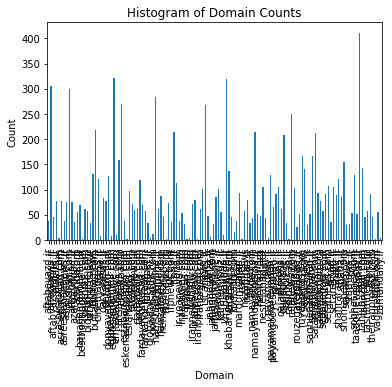

In [148]:
df = articles_top_topics.groupby('domain').count().reset_index()
df.plot(x='domain', y='concepts', kind='bar', legend=False)
plt.xlabel('Domain')
plt.ylabel('Count')
plt.title('Histogram of Domain Counts')
plt.show()

In [149]:
from sklearn.preprocessing import LabelEncoder

def create_umap_plot(umap_embedding, hover_data, labels=None, legend=None):
    
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    fig = go.Figure(data=go.Scatter(
        x=umap_embedding.embedding_[:, 0],
        y=umap_embedding.embedding_[:, 1],
        mode='markers',
        marker=dict(
            size=8,
            color=labels_encoded,
            opacity=0.5
        ),
    ))
    
    if legend:
        label_map = {code: name for code, name in zip(label_encoder.classes_, labels)}
        # Update legend with label names and colors
        fig.update_traces(showlegend=True, legendgroup="group", name=legend, text=[label_map[code] for code in labels_encoded])
        # Update layout with legend configuration
        fig.update_layout(
            title='Top2Vec Topic Embeddings',
            xaxis=dict(title='UMAP Dimension 1'),
            yaxis=dict(title='UMAP Dimension 2'),
            legend=dict(
                title='Legend',
                orientation='h',
                yanchor='bottom',
                y=1.02,
                xanchor='right',
                x=1,
                itemsizing='constant'  # Ensures legend items are the same size
            )
        )
    
    # fig['data'][0]['showlegend']=True
    # fig['data'][0]['name']=legend
    
    return fig

offline.init_notebook_mode(connected=True)
output_notebook()
label='gpt_label'
info_dict = {
    # 'headlines':article_info_db['title'].tolist()[:num_sampled_docs],
    # 'topics_numbers':article_info_db['Topic_Number'].tolist()[:num_sampled_docs],
    # 'label':article_info_db[label].tolist()[:num_sampled_docs]
}
topic_plot = create_umap_plot(umap_embedding, pd.DataFrame(info_dict), articles_top_topics[label][:num_sampled_docs], 'Political Alignment')
topic_plot.write_html('../../output/iran/test_top_topic_plot_' + label + '.html')
# output_file('../../output/iran/test_topic_plot_' + label + '.html')
# save([topic_plot], filename='../../output/iran/test_topic_plot_' + label + '.html', title=label)

Loading BokehJS ...

KeyError: 0

/tmp/ipykernel_16526/2541565962.py:28: UserWarning:

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



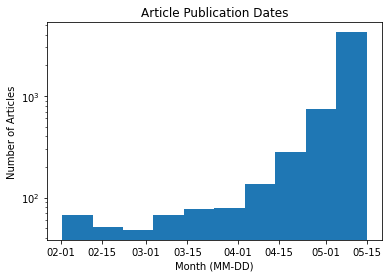

In [240]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
# Convert the dates column to datetime

begin = datetime.strptime('2024-02-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end = datetime.strptime('2024-05-16 00:00:00', '%Y-%m-%d %H:%M:%S')
# mapping_clean = mapping[(mapping['date_published'] > begin) & (mapping['date_published'] < end)]

# plot_topic_distribution(mapping_topic)
import pandas as pd

# Assuming "article_df" is the DataFrame containing the "date_published" column
article_df['date_published'] = pd.to_datetime(article_df['date_published'], errors='coerce')
dates = article_df[(article_df['date_published'] > begin) & (article_df['date_published'] < end)][['date_published']]
dates = dates.sort_values('date_published')  # Sort the DataFrame by 'date_published'
dates.dropna(inplace=True)
plt.hist(dates['date_published'], log=True)

# Modify the x-axis tick format
# plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Add labels and a title
plt.xlabel('Month (MM-DD)')
plt.ylabel('Number of Articles')
plt.title('Article Publication Dates')

plt.ylim(ymin=0)
plt.savefig('../../output/articles_over_time.png', dpi=300, bbox_inches='tight')
plt.show()
